In [2]:
import gensim
import numpy as np
import pandas as pd
import sys, time, os, warnings 
from collections import Counter 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import torchvision.models as models
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
# pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl
# pip3 install torchvision


C:\Users\Pierre\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

In [3]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./Data/Flicker8k_Dataset/train/"
## The location of the caption file
dir_Flickr_text = "./data/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg files in Flicker8k: {}".format(len(jpgs)))

The number of jpg files in Flicker8k: 8091


In [73]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])


df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Using TensorFlow backend.


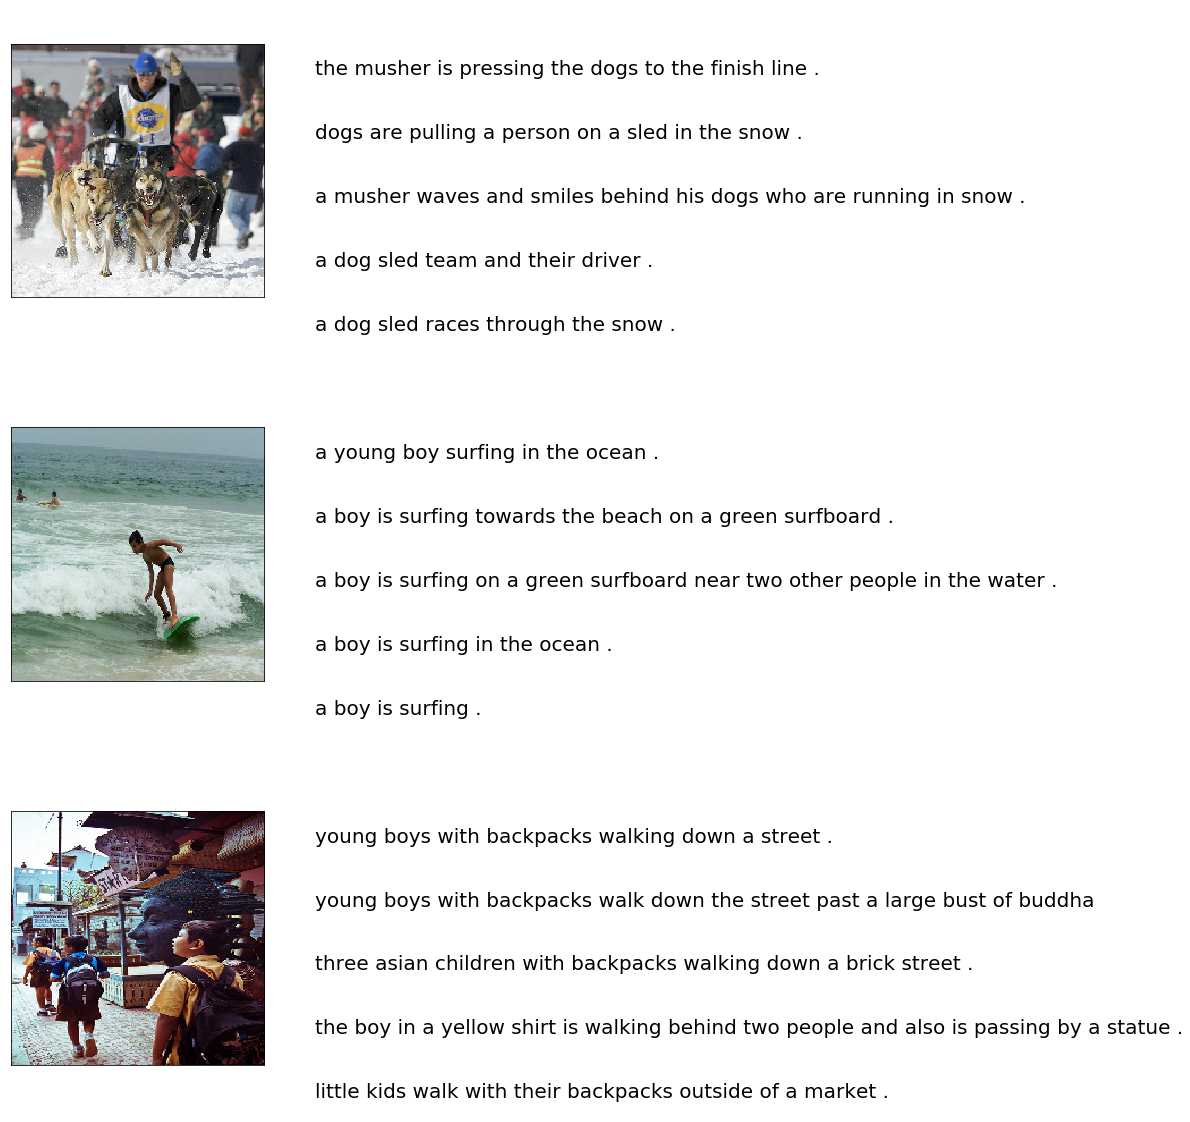

In [5]:
from keras.preprocessing.image import load_img, img_to_array

npix = 224
target_size = (npix,npix,3)

def get_random_pictures(n_pictures):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=n_pictures)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(n_pictures,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(n_pictures,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
get_random_pictures(3)

# Sentence Processing 

In [95]:
def get_sentence_embedding(sentence, model):
    embeddings = np.array([model.word_vec(word) for word in sentence.split() if word in model.wv.vocab.keys()])
    if embeddings.ndim == 2:
        return np.sum(embeddings.T,axis=1)
    elif embeddings.ndim == 1:
        return embeddings

In [79]:
text_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

In [80]:
test = get_sentence_embedding('This is a test', text_model)

# Image Processing 

In [9]:
image_model = models.resnet18(pretrained=True)

In [10]:
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in image_model.parameters():
    param.requires_grad = False
image_model = image_model.to(device)

In [63]:
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './Data/Flicker8k_Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, ""),
                                          data_transforms[x])
                  for x in ['train']}

image_datasets['train'].classes = uni_filenames
image_datasets['train'].class_to_idx = {image_datasets['train'].classes[i]: i for i in range(len(image_datasets['train'].classes))}

for i in range(len(image_datasets['train'].imgs)):
    lst = list(image_datasets['train'].imgs[i])
    lst[1] = image_datasets['train'].class_to_idx[lst[0].replace('./Data/Flicker8k_Dataset/train\\','')]
    image_datasets['train'].imgs[i] = tuple(lst)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}

class_names = image_datasets['train'].classes


In [ ]:
'''classes = []

for i in range(len(image_datasets['train'].imgs)):
    lst = list(image_datasets['train'].imgs[i])
    lst[1] = df_txt["caption"].loc[df_txt["filename"]==lst[0].replace('./Data/Flicker8k_Dataset/train\\','')].values
    image_datasets['train'].imgs[i] = tuple(lst)
'''
'''
class ImagesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, uni_filenames, df_txt, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df_txt = df_txt
        self.root_dir = root_dir
        self.transform = transform
        self.uni_filenames = uni_filenames

    def __len__(self):
        return len(self.df_txt)

    def __getitem__(self, idx):
        filename = uni_filenames[index]
        img_name = os.path.join(self.root_dir,
                                filename)
        image = io.imread(img_name)
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        sample = {'image': image, 'captions': captions}

        if self.transform:
            sample = self.transform(sample)

        return sample
'''

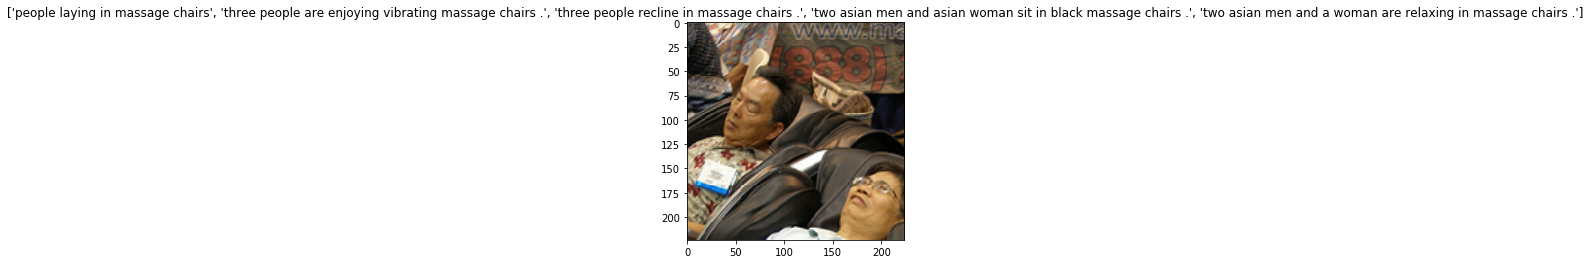

In [69]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
captions = list(df_txt["caption"].loc[df_txt["filename"]==class_names[classes]].values)
imshow(out, title=captions)

In [70]:
for i, (inputs, labels) in enumerate(dataloaders['train']):
    inputs = inputs.to(device)
    print(inputs.shape)
    print(image_model(inputs).shape)
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [74]:
def get_random_data(batch_size):
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        #image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).T[np.newaxis, :]
        #image.swapaxes(2, 3)
        #print(image.shape)
        image, _ = next(iter(dataloaders['train']))
        image = image.numpy()
        return image_model(torch.from_numpy(image).type('torch.FloatTensor')).shape, get_sentence_embedding(random_caption, text_model).shape

In [75]:
get_random_data(1)

(torch.Size([1, 1000]), (300,))

In [98]:
batch_size = 1
for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)[np.newaxis, :].swapaxes(2,3).swapaxes(1,2)
        print(image_model(torch.from_numpy(image).type('torch.FloatTensor')), get_sentence_embedding(random_caption, text_model))

RuntimeError: size mismatch, m1: [1 x 30720], m2: [512 x 1000] at c:\new-builder_3\win-wheel\pytorch\aten\src\th\generic/THTensorMath.cpp:2070

In [144]:
image.swapaxes(2,3).swapaxes(1,2).shape,image.shape

((1, 500, 3, 357), (1, 3, 357, 500))

In [145]:
image.shape

(1, 3, 357, 500)

In [39]:
image[0,:,:,:].shape

(333, 500, 3)

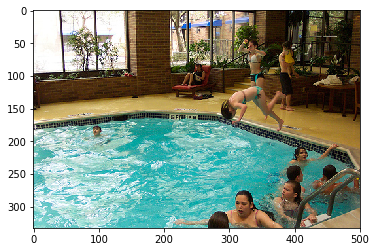

In [40]:
plt.imshow(image[0,:,:,:])

In [102]:
# Generating the representations
images = torch.zeros([df_txt.shape[0], 1000], dtype=torch.float)
captions = torch.zeros([df_txt.shape[0], 300], dtype=torch.float)

for i, (input, label) in enumerate(dataloaders['train']):
    labels = list(df_txt["caption"].loc[df_txt["filename"]==class_names[label]].values)
    im = image_model(input)
    for j in range(len(labels)):
        capt = get_sentence_embedding(labels[j], text_model)
        if capt.size == 300:
            images[i+j] = im
            captions[i+j] = torch.from_numpy(capt)

# Sparse Autoencoder


In [103]:
import torch.nn as nn
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(n_inp, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_inp)

    def forward(self, x):
        encoded = F.relu(self.encoder(x)) # or sigmoid
        decoded = F.sigmoid(self.decoder(encoded))
        return encoded, decoded
    

In [119]:
# Model parameters
BATCH_SIZE = 5
N_INP = 1000 + 300 # Image representation + Word2Vec
N_HIDDEN = 1800
N_EPOCHS = 20
LEARNING_RATE = 1e-3

use_kl = False

# If using KL-divergence
BETA = 3 # Importance of the KL-divergence penalty term
RHO = 0.01 # Target sparsity

if use_kl :
    rho = torch.FloatTensor([RHO for _ in range(N_HIDDEN)]).unsqueeze(0)

# If using L1 regularization
LAMBDA = 1e-5 # L1 penalty term

In [120]:
auto_encoder = SparseAutoencoder(N_INP, N_HIDDEN)
optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)

In [121]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = F.softmax(p)
    q = F.softmax(q)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))

    return s1 + s2

In [122]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [123]:
dataset = torch.cat((images, captions), 1)

print(dataset.shape)

for epoch in range(N_EPOCHS):
    
    encoded, decoded = auto_encoder(dataset)

    #MSE_loss = (x - decoded) ** 2
    #MSE_loss = MSE_loss.sum() / (BATCH_SIZE*x.shape[1]) 
    #MSE_loss = MSE_loss.mean()
    
    mse_loss = F.mse_loss(decoded, dataset)

    rho_hat = torch.sum(encoded, dim=0, keepdim=True)/BATCH_SIZE
    
    if use_kl:
        sparsity_penalty = BETA * kl_divergence(rho, rho_hat)
        loss = mse_loss + sparsity_penalty
    else:
        l1_reg = LAMBDA * l1_penalty(encoded)
        loss = mse_loss + l1_reg
    
    optimizer.zero_grad() # Clears the gradient
    loss.backward() # Computes gradient
    optimizer.step() # Update rule

    print("Epoch: [%3d], Loss: %.4f" %(epoch + 1, loss.data))
    print("Average sparsity : ",  rho_hat.sum()/N_HIDDEN)


torch.Size([40460, 1300])
Epoch: [  1], Loss: 29.3899
Average sparsity :  tensor(322.5132, grad_fn=<DivBackward0>)
Epoch: [  2], Loss: 5.4376
Average sparsity :  tensor(56.4102, grad_fn=<DivBackward0>)
Epoch: [  3], Loss: 3.9442
Average sparsity :  tensor(39.8245, grad_fn=<DivBackward0>)
Epoch: [  4], Loss: 3.6740
Average sparsity :  tensor(36.8399, grad_fn=<DivBackward0>)
Epoch: [  5], Loss: 3.4138
Average sparsity :  tensor(33.9643, grad_fn=<DivBackward0>)
Epoch: [  6], Loss: 3.1655
Average sparsity :  tensor(31.2174, grad_fn=<DivBackward0>)
Epoch: [  7], Loss: 2.9303
Average sparsity :  tensor(28.6137, grad_fn=<DivBackward0>)
Epoch: [  8], Loss: 2.7059
Average sparsity :  tensor(26.1282, grad_fn=<DivBackward0>)
Epoch: [  9], Loss: 2.4877
Average sparsity :  tensor(23.7096, grad_fn=<DivBackward0>)
Epoch: [ 10], Loss: 2.2779
Average sparsity :  tensor(21.3828, grad_fn=<DivBackward0>)
Epoch: [ 11], Loss: 2.0813
Average sparsity :  tensor(19.2003, grad_fn=<DivBackward0>)
Epoch: [ 12], L

In [124]:
# Test
image_test = torch.empty(1, 1000).uniform_(0, 1)
caption_test = torch.empty(1, 300).uniform_(0, 1)

x = torch.cat((image_test, caption_test), 1)
encoded, decoded = auto_encoder(x)

print(x)
i=0
for e in encoded[0]:
    if e > 1e-3:
        print(e)
        i+=1
print(i, "elements different from 0")
print(torch.abs(x-decoded))
print(torch.sum(torch.abs(x-decoded)))

tensor([[0.3491, 0.4745, 0.3079,  ..., 0.5336, 0.1154, 0.2350]])
tensor(0.3714, grad_fn=<SelectBackward>)
tensor(0.2276, grad_fn=<SelectBackward>)
tensor(0.1037, grad_fn=<SelectBackward>)
tensor(0.4334, grad_fn=<SelectBackward>)
tensor(0.4779, grad_fn=<SelectBackward>)
tensor(0.3261, grad_fn=<SelectBackward>)
tensor(0.2141, grad_fn=<SelectBackward>)
tensor(0.5460, grad_fn=<SelectBackward>)
tensor(0.6902, grad_fn=<SelectBackward>)
tensor(0.4018, grad_fn=<SelectBackward>)
tensor(0.0808, grad_fn=<SelectBackward>)
tensor(0.2881, grad_fn=<SelectBackward>)
tensor(0.3623, grad_fn=<SelectBackward>)
tensor(0.0828, grad_fn=<SelectBackward>)
tensor(0.0817, grad_fn=<SelectBackward>)
tensor(0.1418, grad_fn=<SelectBackward>)
tensor(0.3719, grad_fn=<SelectBackward>)
tensor(0.0780, grad_fn=<SelectBackward>)
tensor(0.1284, grad_fn=<SelectBackward>)
tensor(0.0509, grad_fn=<SelectBackward>)
tensor(0.6667, grad_fn=<SelectBackward>)
tensor(0.2988, grad_fn=<SelectBackward>)
tensor(0.2882, grad_fn=<SelectBac

tensor(0.3216, grad_fn=<SelectBackward>)
tensor(0.0039, grad_fn=<SelectBackward>)
tensor(0.1385, grad_fn=<SelectBackward>)
tensor(0.1298, grad_fn=<SelectBackward>)
tensor(0.2389, grad_fn=<SelectBackward>)
tensor(0.0465, grad_fn=<SelectBackward>)
tensor(0.1961, grad_fn=<SelectBackward>)
tensor(0.7540, grad_fn=<SelectBackward>)
tensor(0.4673, grad_fn=<SelectBackward>)
tensor(0.0518, grad_fn=<SelectBackward>)
tensor(0.1523, grad_fn=<SelectBackward>)
tensor(0.0477, grad_fn=<SelectBackward>)
tensor(0.4499, grad_fn=<SelectBackward>)
tensor(0.0060, grad_fn=<SelectBackward>)
tensor(0.0920, grad_fn=<SelectBackward>)
tensor(0.0469, grad_fn=<SelectBackward>)
tensor(0.2207, grad_fn=<SelectBackward>)
tensor(0.6086, grad_fn=<SelectBackward>)
tensor(0.2624, grad_fn=<SelectBackward>)
tensor(0.1957, grad_fn=<SelectBackward>)
tensor(0.0822, grad_fn=<SelectBackward>)
tensor(0.2690, grad_fn=<SelectBackward>)
tensor(0.4181, grad_fn=<SelectBackward>)
tensor(0.0376, grad_fn=<SelectBackward>)
tensor(0.2394, g

tensor(0.0187, grad_fn=<SelectBackward>)
tensor(0.1514, grad_fn=<SelectBackward>)
tensor(0.2071, grad_fn=<SelectBackward>)
tensor(0.1983, grad_fn=<SelectBackward>)
tensor(0.5489, grad_fn=<SelectBackward>)
tensor(0.5530, grad_fn=<SelectBackward>)
tensor(0.1759, grad_fn=<SelectBackward>)
tensor(0.1203, grad_fn=<SelectBackward>)
tensor(0.6902, grad_fn=<SelectBackward>)
tensor(0.1225, grad_fn=<SelectBackward>)
tensor(0.7531, grad_fn=<SelectBackward>)
tensor(0.0515, grad_fn=<SelectBackward>)
tensor(0.0897, grad_fn=<SelectBackward>)
tensor(0.5712, grad_fn=<SelectBackward>)
tensor(0.6862, grad_fn=<SelectBackward>)
tensor(0.1410, grad_fn=<SelectBackward>)
tensor(0.2510, grad_fn=<SelectBackward>)
tensor(0.1969, grad_fn=<SelectBackward>)
tensor(0.1689, grad_fn=<SelectBackward>)
tensor(0.1622, grad_fn=<SelectBackward>)
tensor(0.0327, grad_fn=<SelectBackward>)
tensor(0.2267, grad_fn=<SelectBackward>)
tensor(0.1506, grad_fn=<SelectBackward>)
tensor(0.3697, grad_fn=<SelectBackward>)
tensor(0.0549, g

# Autoassociative memory - Hopfield Network

In [54]:
# Get autoencoder's hidden representations
x = torch.cat((images_train, captions_train), 1)
encoded, _ = auto_encoder(x)

In [55]:
def calculate_weights(learning_patterns):
    
    w = (np.transpose(learning_patterns) @ learning_patterns) / learning_patterns.shape[0]
    np.fill_diagonal(w, 0)
    
    return w

In [56]:
def energy(x, w):
    
    energy = 0
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            energy -= w[i, j]*x[i]*x[j]
            
    return energy

In [57]:
def update_rule_little_model(x, w):

    x = x @ w
    #x = np.where(x>=0, 1, -1)
    #x = np.tanh(x)

    return x

In [58]:
def recall(x, w):
    
    print("Initial energy : ", energy(x, w))
    x_new = update_rule_little_model(x, w)
    i = 0 # To stop if no convergence
    print("Energy : ", energy(x_new, w))
    while(np.array_equal(x_new, x) == False and i<10):
        x = x_new
        x_new = update_rule_little_model(x, w)
        print("Energy : ", energy(x_new, w))
        i+=1
        
    return x_new, i

In [59]:
encoded = encoded.detach().numpy()
print(encoded)
w = calculate_weights(learning_patterns=encoded)
x, _ = recall(encoded[2,:], w)
print(x.shape)
print(encoded[2,:])
print(x)
print(np.sum(np.abs(x-encoded[2,:])))

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        2.2600746 0.        ... 0.        0.        0.       ]
 [0.        0.3181247 0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
Initial energy :  -8550.918475982548
Energy :  -51848276.32394375
Energy :  -375481217982.0229
Energy :  -2753086955377024.0
Energy :  -2.020736350760598e+19
Energy :  -1.4833648162475466e+23
Energy :  -1.0889102808537072e+27
Energy :  -7.993498971463502e+30
Energy :  -5.8678885952541e+34
Energy :  -4.307515011647521e+38
Energy :  -inf
Energy :  -inf
(1800,)
[0.        2.2600746 0.        ... 0.        0.        0.       ]
[0.000000e+00 8.860412e+20 0.000000e+00 ... 0.000000e+00 0.000000e+00
 0.000000e+00]
1.7482015e+23
